# *Optical Tweezers* | Lab-Session #4
## Feb-18-2021 13:45

This jupyter notebook is a used to collect and analyse data during today's lab session

In [2]:
# Import the relevant libraries
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt 
import scipy.constants as const
import scipy.signal
import os
from csvlib import *
from scipy.optimize import curve_fit
from IPython.display import display
from PIL import Image
from tqdm import tqdm

# Display mpl in notebook format
%matplotlib inline

# Data Collection

Data were collected for the calibration of the optical trap, by trapping a bead and plotting the power spectrum of each coordinate.

In [17]:
# open CSV files to numpy array
csvs = list_csv(PRINT='True')   # Lists CSV files in a given directory
indx = 22                       # Index of data file in the list
DATA = pd.read_csv(csvs[indx])  # Gets the CSV file as a Pandas Data Frame
data = DATA.to_numpy().T        # Gets data as a numpy array§

## Store the different variables
t = np.linspace(0,5,500000)
x = data[0]
y = data[1]
z = data[2]

# DATA                            # Prints pretty PANDAS data frame

List of .csv files in .
	 0 : TRP-100-0.csv
	 1 : TRP-100-1.csv
	 2 : TRP-100-2.csv
	 3 : TRP-100-3.csv
	 4 : TRP-100-4.csv
	 5 : TRP-150-0.csv
	 6 : TRP-150-1.csv
	 7 : TRP-150-2.csv
	 8 : TRP-150-3.csv
	 9 : TRP-150-4.csv
	 10 : TRP-200-0.csv
	 11 : TRP-200-1.csv
	 12 : TRP-200-2.csv
	 13 : TRP-200-3.csv
	 14 : TRP-200-4.csv
	 15 : TRP-200-CAL-0.csv
	 16 : TRP-200-CAL-1.csv
	 17 : TRP-200-CAL-2.csv
	 18 : TRP-250-0.csv
	 19 : TRP-250-1.csv
	 20 : TRP-250-2.csv
	 21 : TRP-250-3.csv
	 22 : TRP-250-4.csv
	 23 : TRP-50-0.csv
	 24 : TRP-50-1.csv
	 25 : TRP-50-2.csv
	 26 : TRP-50-3.csv
	 27 : TRP-50-4.csv


# Data Analysis

We are first going to plot the coordinates as imported form the qpd as a function of time

  0%|          | 0/3 [00:00<?, ?it/s]

Data set under consideration: TRP-250-4.csv
The trap attempt is: TRP-250-4.csv

Here is an image from the trap


100%|██████████| 3/3 [00:02<00:00,  1.33it/s]


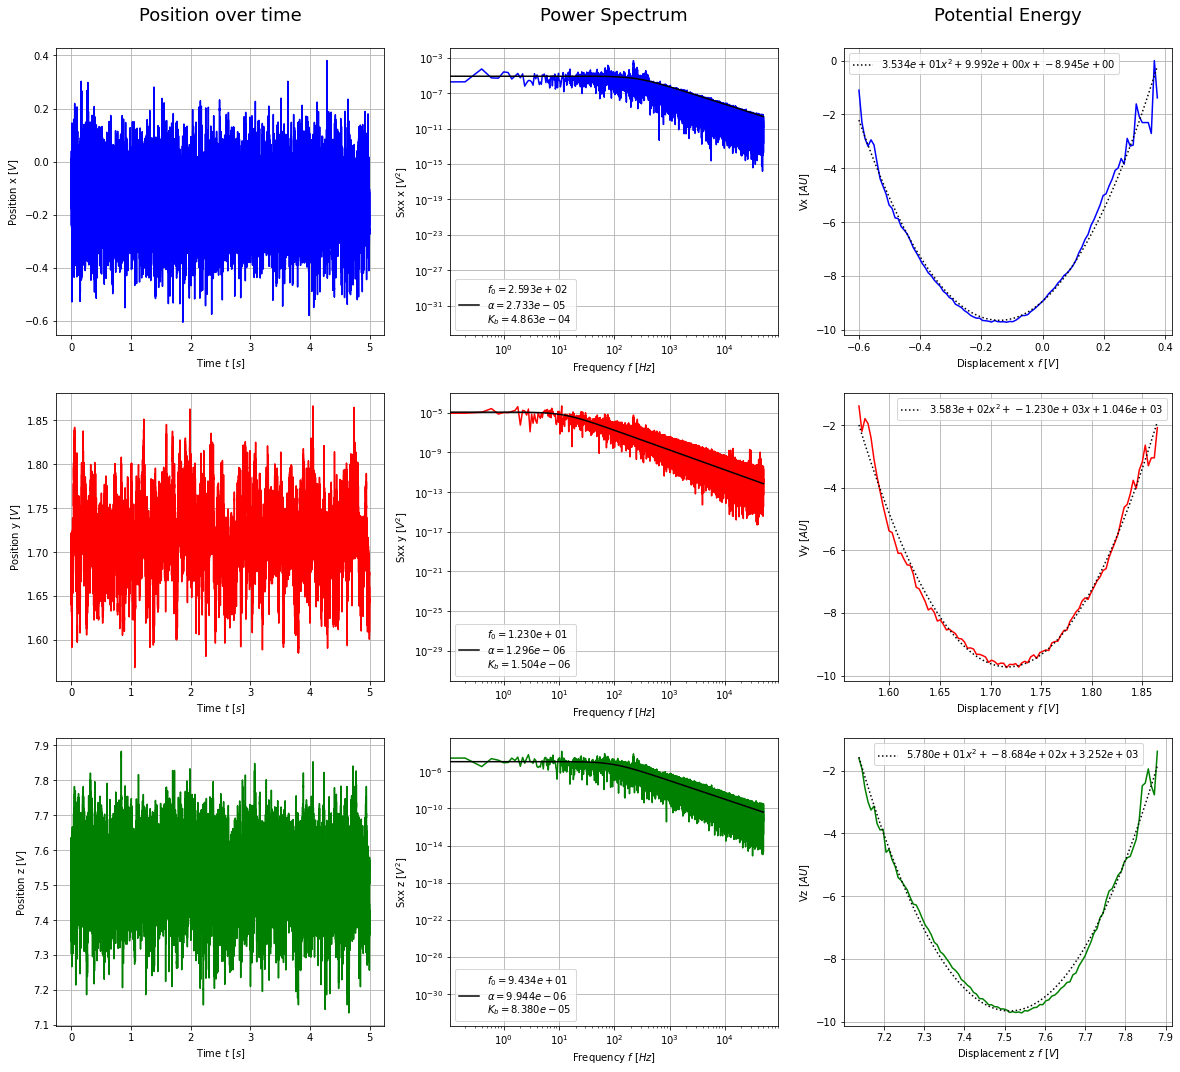

In [19]:
# All of them together

# Print Data frame information

print("Data set under consideration: "+csvs[indx])      # Print filename
trp = csvs[indx].split('_')[0]                          # Get trap number
print("The trap attempt is: "+trp)                      # Print trap number
print("\nHere is an image from the trap")
# img = Image.open(trp+".tif")
# scale = 0.5
# img = img.resize((int(img.size[0]*scale),int(img.size[1]*scale)))
# display(img)

# Function to attempt to fit the power spectrum with
eta = 8.9e-4 #2.414e-5
d   = 2e-6
T = 294.15
beta = 3*np.pi*eta*d
Sxx = lambda f,alpha: (const.k*T)/(np.pi**2 * beta*(f**2 + (alpha/(2*np.pi*beta))**2))
SxxII = lambda f,f_0,alpha: alpha/(f**2+f_0**2)
poly = lambda x,a,b,c: a*x**2 + b*x + c

fig = plt.figure(figsize=(20,18))
colors = ['b','r','g']

# Calculate the power spectrum 
coords = [x,y,z]
labels = ['x','y','z']
fs = ((max(t)-min(t))/len(t))**(-1)
Nbins = 100

for i in tqdm(range(0,3)):
    ax = fig.add_subplot(331+i*3)
    if i==0: ax.set_title('Position over time\n',fontsize=18)
    ax.set_xlabel(r'Time $t\ [s]$')
    ax.set_ylabel('Position ' + labels[i] + r' $ [V]$')
    ax.grid()

    ax.plot(t,coords[i],c=colors[i])

    # Adding the necessary plot elements
    ax = fig.add_subplot(332+i*3)
    if i==0: ax.set_title('Power Spectrum\n',fontsize=18)
    ax.set_xlabel(r'Frequency $f\ [Hz]$')
    ax.set_ylabel('Sxx ' + labels[i] + r' $ [V^2]$')
    ax.grid()

    # Obtaining the power spectrum
    f,pxx = scipy.signal.periodogram(coords[i],fs=fs,scaling='spectrum')

    # Fit the curve with the SxxII model
    A_0 = (const.k*294.15/(np.pi**2*3*np.pi*eta*d))
    f_0 = 1e-20/(2*np.pi**2*3*eta*d)
    params, _ = curve_fit(SxxII,f,pxx,p0=[f_0,A_0],maxfev=1000)
    k_b = params[1]*3*eta*d/(np.pi*d)

    # Plot the power spectrum
    ax.plot(f,pxx,c=colors[i])

    # Plot the fit
    ax.plot(f,SxxII(f,*params),c='k',\
            label=r'$f_0 = %1.3e$'%(params[0])+
            '\n'+r'$\alpha = %1.3e$'%(params[0]*(2*np.pi**2*3*eta*d))+
            '\n'+r'$K_b = %1.3e$'%k_b)
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.legend()

    # Adding the necessary plot elements
    ax = fig.add_subplot(333+i*3)
    if i==0: ax.set_title('Potential Energy\n',fontsize=18)
    ax.set_xlabel('Displacement '+labels[i]+r' $f\ [V]$')
    ax.set_ylabel('V' + labels[i] + r' $ [AU]$')
    ax.grid()

    # Obtaining the histogram of the data
    hist, xx = np.histogram(coords[i],bins=Nbins)
    xx = np.array([(xx[i]+xx[i+1])/2 for i in range(len(xx)-1)])

    # Plot the potential energy
    ax.plot(xx,-np.log(hist),c=colors[i])
    
    # Obtaining the best fit curve for the histogram
    params = np.polyfit(xx,-np.log(hist), 2)
    ax.plot(xx,poly(xx,*params),ls=':',c='k',\
            label=r'$ %1.3e x^2 + %1.3e x + %1.3e $'%tuple(params))
    ax.legend()

Data set under consideration: TRP3_003.csv
The trap attempt is: TRP3

Here is an image from the trap


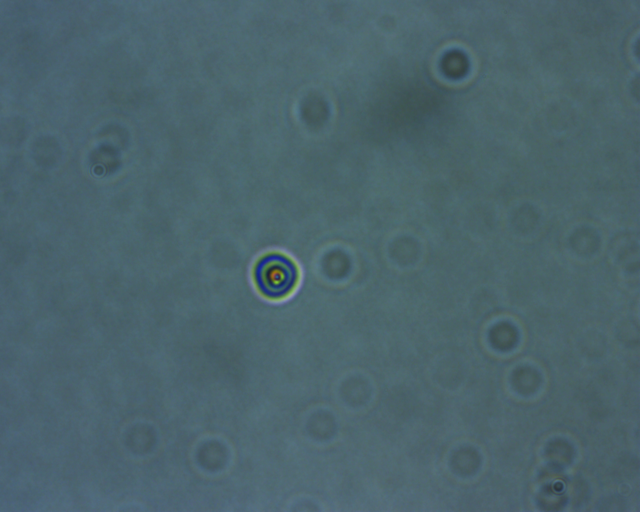

In [4]:
# Print Data frame information

print("Data set under consideration: "+csvs[indx])      # Print filename
trp = csvs[indx].split('_')[0]                          # Get trap number
print("The trap attempt is: "+trp)                      # Print trap number
print("\nHere is an image from the trap")
img = Image.open(trp+".tif")
scale = 0.5
img = img.resize((int(img.size[0]*scale),int(img.size[1]*scale)))
display(img)

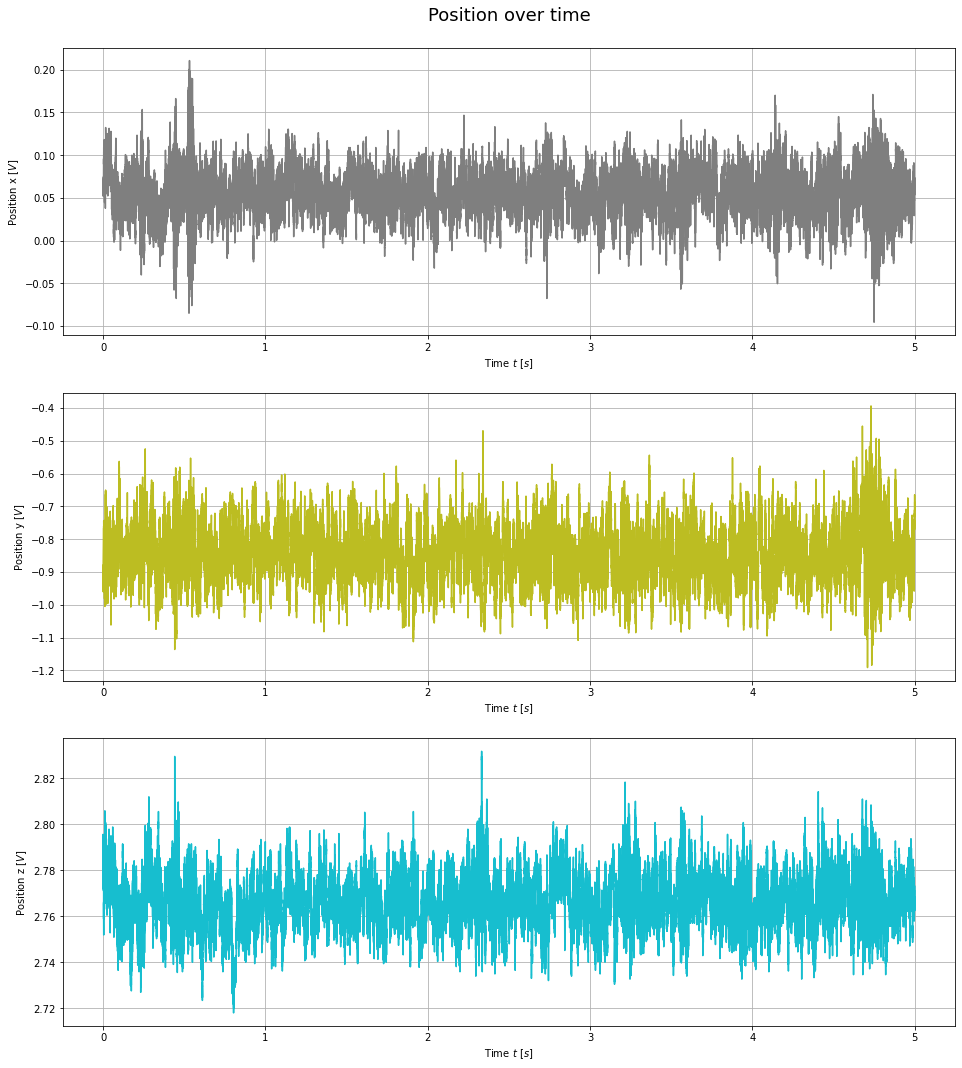

In [6]:
# Plotting X-Y-Z
# Set up figure
fig = plt.figure(figsize=(16,18))

coords = [x,y,z]
labels = ['x','y','z']

for i in range(0,3):
    ax = fig.add_subplot(311+i)
    if i==0: ax.set_title('Position over time\n',fontsize=18)
    ax.set_xlabel(r'Time $t\ [s]$')
    ax.set_ylabel('Position ' + labels[i] + r' $ [V]$')
    ax.grid()

    ax.plot(t,coords[i],c='C%d'%(i+7))


# Potential Energy

Now we will plot the potential energy of each of those thingys

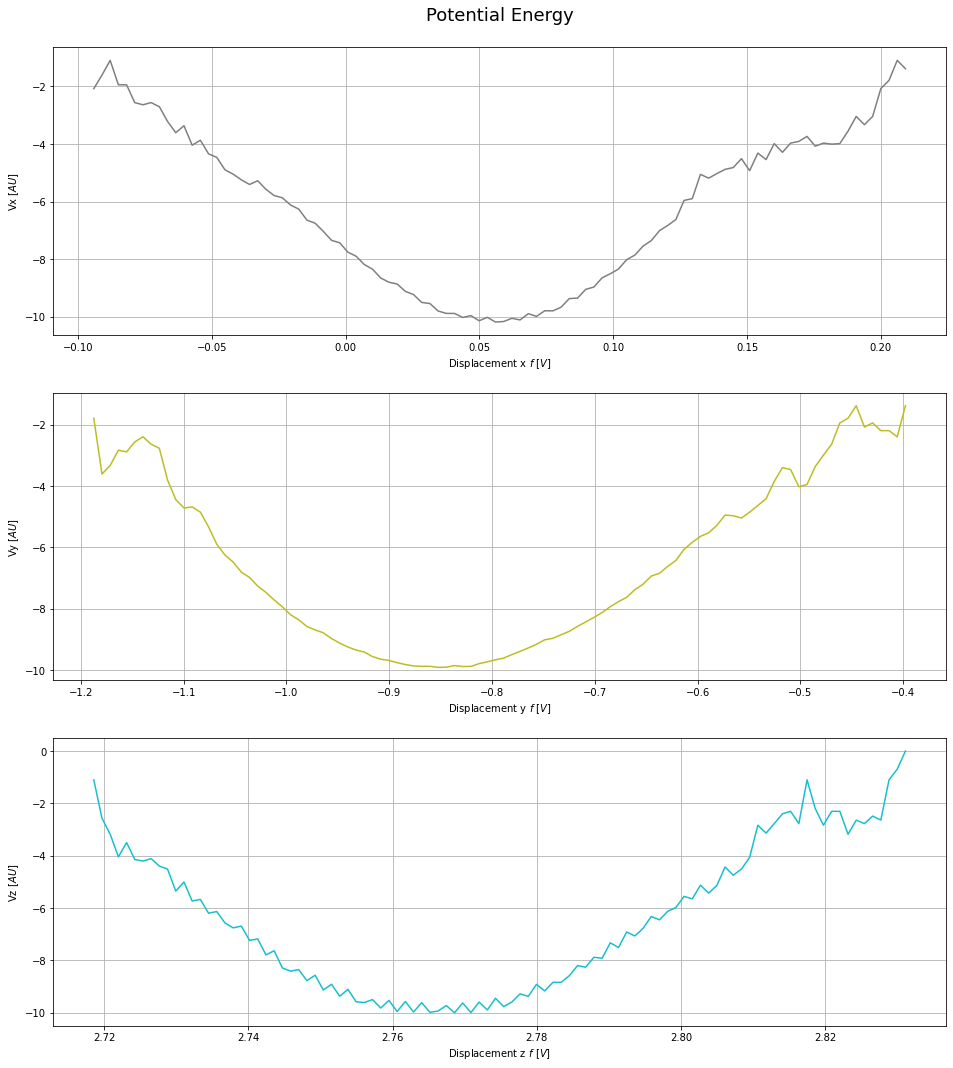

In [8]:
# Potential energy
# Function to attempt to fit the power spectrum with
fig = plt.figure(figsize=(16,18))

# Calculate the power spectrum 
coords = [x,y,z]
labels = ['x','y','z']
Nbins = 100

for i in range(0,len(coords)):
    # Adding the necessary plot elements
    ax = fig.add_subplot(311+i)
    if i==0: ax.set_title('Potential Energy\n',fontsize=18)
    ax.set_xlabel('Displacement '+labels[i]+r' $f\ [V]$')
    ax.set_ylabel('V' + labels[i] + r' $ [AU]$')
    ax.grid()

    # Obtaining the histogram of the data
    hist, xx = np.histogram(coords[i],bins=Nbins)
    xx = [(xx[i]+xx[i+1])/2 for i in range(len(xx)-1)]

    # Plot the potential energy
    ax.plot(xx,-np.log(hist),c='C%d'%(i+7))
    # ax.legend()